figures for the 10 minute talk at EARS

In [1]:
from pathlib import Path
import itertools as itt

import joblib as jl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import pandas as pd
import seaborn as sns
from IPython.display import display
from statannot import add_stat_annotation
from cycler import cycler

from src.data.region_map import region_map
from src.metrics.consolidated_dprimes import _load_site_formated_raste, single_cell_dprimes, full_dPCA_dprimes
from src.data.dPCA import _cpp_dPCA, format_raster
from src.visualization.fancy_plots import _raster, unit_line
from src.metrics.significance import _significance
from src.metrics.dprime import flip_dprimes
from src.metrics.reliability import signal_reliability
from src.data.rasters import raster_from_sig
from src.data.load import load

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-04-06 175050.log
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:66: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:76: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:81: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
[numexpr.utils INFO] NumExpr defaulting to 8 threads.


In [2]:
#general plottin formating
plt.style.use('dark_background')

light_color_cycle = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

trans_color_map = {'silence': '#377eb8',  # blue
                   'continuous': '#ff7f00',  # orange
                   'similar': '#4daf4a',  # green
                   'sharp': '#a65628'}  # brown

params = {'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': light_color_cycle,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [4,4],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial',
          'legend.loc': 'upper right',
          'legend.frameon': False,
          'legend.fontsize': 15,
          'legend.markerscale': 3,
          }

widescreen = [13.3, 7.5]

plt.rcParams.update(params)

In [3]:
# pulls DF, removes unused columns and data, refactor redunant id columns and create probe_id
DF = jl.load(Path(f'../data/210302_consolidated_summary_DF_alpha_0.05/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))

# no need for means or mean policy, working on permutations only
ff_probe = DF.probe != 'mean'
ff_pairs = DF.context_pair != 'mean'
ff_stim = DF.stim_type == 'permutations'
ff_mean = DF.mean_signif_type == 'shuffles'

ff_analylis = DF.analysis.isin(['SC', 'fdPCA'])
ff_corr = DF.mult_comp_corr == 'consecutive_3'
ff_metric = DF.metric.isin(['significant_abs_mass_center', 'significant_abs_mean', 'significant_abs_sum'])

good_cols =['analysis', 'mult_comp_corr', 'region', 'siteid',  'cellid', 'context_pair',
            'probe', 'metric', 'value']
filtered = DF.loc[ff_stim & ff_mean & ff_pairs & ff_probe & ff_analylis & ff_corr & ff_metric, good_cols]

# rename metrics and analysis for ease of ploting
filtered['metric'] = filtered['metric'].replace({'significant_abs_mass_center': 'center of mass (ms)',
                                                 'significant_abs_mean': "mean d'",
                                                 'significant_abs_sum': "integral (d'*ms)"})
filtered['analysis'] = filtered['analysis'].replace({'SC': 'single cell',
                                                     'fdPCA': 'population'})

filtered['id'] = filtered['cellid'].fillna(value=filtered['siteid'])
filtered = filtered.drop(columns=['cellid', 'siteid'])

filtered['value'] = filtered['value'].fillna(value=0)

# creates a new column relating probe with  context pairs
ctx = np.asarray([row.split('_') for row in filtered.context_pair], dtype=int)
prb = np.asarray(filtered.probe, dtype=int)

silence = ctx == 0
same = ctx == prb[:,None]
different = np.logical_and(~silence, ~same)

name_arr = np.full_like(ctx, np.nan, dtype=object)
name_arr[silence] = 'silence'
name_arr[same] = 'same'
name_arr[different] = 'diff'
comp_name_arr = np.apply_along_axis('_'.join, 1, name_arr)

# swaps clasification names to not have repetitions i.e. diff_same == same_diff
comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'
comp_name_arr[np.where(comp_name_arr == 'diff_silence')] = 'silence_diff'
comp_name_arr[np.where(comp_name_arr == 'diff_same')] = 'same_diff'
comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'

filtered['trans_pair'] = comp_name_arr

ord_cols = ['analysis', 'region', 'id', 'context_pair', 'trans_pair', 'probe', 'metric', 'value']
pivot_idx = [col for col in ord_cols if col not in ['value', 'metric']]
pivoted = filtered.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc='first').reset_index()

In [4]:
# counts the total number of values for each comparison (SC, fDPCA) x (sile_diff, sile_same, diff_diff, same_diff)
# counts the proportion of signifciant vs non singificant(zero-zero) values
# decimates the more numerous comparisons??

# set the array to group by id, context_pair, and probe. Keeping analysis, region and transision_pair
# the final array should have analysis, region and trans pair as rowns, and total count, and significants as columns

def nozero_mean(arr):
    arr[arr==0] = np.nan
    return np.nanmean(arr)

def nozero_count(arr):
    return np.sum(arr>0)

group_ready = pivoted.set_index(['analysis', 'region', 'trans_pair']).loc[:, filtered.metric.unique()]
agg_funcs = {'center of mass (ms)': [('mean duration', nozero_mean)],
             "mean d'": [('mean amplitude', nozero_mean),
                                     ('total', 'size'),
                                     ('n_signif', nozero_count)]}

grouped = group_ready.groupby(['analysis', 'region', 'trans_pair']).agg(agg_funcs)
grouped.columns = grouped.columns.droplevel(0)
grouped['significant %'] = grouped.n_signif / grouped.total * 100

## count number of cells or sites with significant contextual effects

In [5]:
for anal in ['single cell', 'population']:
    all_id_df= pivoted.loc[pivoted.analysis == anal, ['id']]
    all_id_count = len(all_id_df.id.unique())

    good_id_df= pivoted.loc[(pivoted.analysis == anal) & (pivoted["integral (d'*ms)"] > 0), ['id']]
    good_id_count = len(good_id_df.id.unique())

    print(f'{anal}\n{good_id_count} of {all_id_count}. {good_id_count/all_id_count*100:.2f}%')

single cell
581 of 862. 67.40%
population
35 of 35. 100.00%


## how many contextual instances per site/cell and on average

In [6]:
goodcount = pivoted.set_index(['analysis', 'id']).loc[:,["integral (d'*ms)"]]
agg_funcs = {"integral (d'*ms)": [('all',np.size),
                                  ('good', nozero_count)]}
goodcount = goodcount.groupby(['analysis','id']).agg(agg_funcs)
goodcount.columns = goodcount.columns.droplevel(0)
goodcount = goodcount.loc[goodcount['good'] > 0]
goodcount['percent'] = goodcount['good'] / goodcount['all'] * 100
# display(goodcount)

for anal in ['single cell', 'population']:
    arr = goodcount.loc[(anal), 'percent'].values
    print(f'{anal}\n{np.mean(arr):.2f}% significant instances on average')

single cell
14.36% significant instances on average
population
47.00% significant instances on average


## count of significant instances

In [7]:
# paired relation plot
# defines the grid (5 * 5) with correct indexing

def pairwise_heatmap(value, up_var, lo_var, analysis, ax=None):
    grid_lab = np.asarray(['sile', 'same', 'diff', 'diff', 'diff'])
    grid_arr = np.full((5,5), np.nan)
    swap_dict = {'self_sile': 'sile_self',
                 'diff_sile': 'sile_diff',
                 'diff_same': 'same_diff',
                 'same_sile': 'sile_same'}

    up_idx = np.triu_indices(5,1)
    lo_idx = np.tril_indices(5,-1)

    # relates labes to upper and lower
    upper_label = [f'{grid_lab[t1]}_{grid_lab[t2]}' for t1, t2 in
             zip(up_idx[0], up_idx[1])]

    lower_label = [f'{grid_lab[t1]}_{grid_lab[t2]}' for t1, t2 in
             zip(lo_idx[0], lo_idx[1])]
    lower_label = [swap_dict[lab] if lab in list(swap_dict.keys()) else lab for lab in lower_label]

    # iterates and fills upper triangle
    up_vals = list()
    for uplab in upper_label:
        up_vals.append(grouped.loc[(analysis, up_var, uplab), value])

    lo_vals = list()
    for lolab in lower_label:
        lo_vals.append(grouped.loc[(analysis, lo_var, lolab), value])

    grid_arr[up_idx] = up_vals
    grid_arr[lo_idx] = lo_vals

    if  ax == None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    im = ax.imshow(grid_arr, cmap='viridis')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(grid_lab)))
    ax.set_yticks(np.arange(len(grid_lab)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(grid_lab)
    ax.set_yticklabels(grid_lab)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over labelse and  set values the first time
    for unique_lab in set(upper_label):
        uy = up_idx[0][upper_label.index(unique_lab)]
        ux = up_idx[1][upper_label.index(unique_lab)]
        text = ax.text(ux, uy, f'{grid_arr[uy, ux]:.2f}',
                           ha="center", va="center", color="w")

    for unique_lab in set(lower_label):
        ly = lo_idx[0][lower_label.index(unique_lab)]
        lx = lo_idx[1][lower_label.index(unique_lab)]
        text = ax.text(lx, ly, f'{grid_arr[ly, lx]:.2f}',
                           ha="center", va="center", color="w")

    ax.set_title(f"{analysis} {value} ({lo_var}\\{up_var})")
    return fig, ax

### single cell

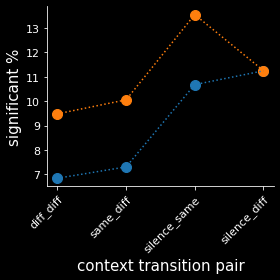

In [8]:
analysis = 'single cell'
value = 'significant %'

fig, ax = plt.subplots()

toplot = grouped.loc[(analysis), (value)]
toplot = toplot.reset_index()
toplot = toplot.pivot(values=value, columns='region', index='trans_pair')
toplot = toplot.reindex(index=['diff_diff', 'same_diff', 'silence_same', 'silence_diff'])

_ = ax.plot(toplot.A1, color='C0', linestyle=':', label='A1')
_ = ax.scatter(range(4), toplot.A1, color='C0', s=100)
_ = ax.plot(toplot.PEG, color='C1', linestyle=':', label='PEG')
_ = ax.scatter(range(4), toplot.PEG, color='C1', s=100)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_ylabel('significant %')
ax.set_xlabel('context transition pair')
fig.set_size_inches(4,4)
title = 'single_cell_signif_percent_plot'

### population

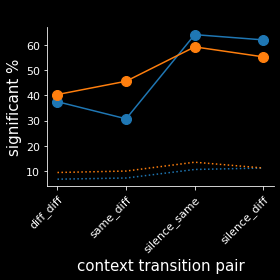

In [9]:
# for the population plots both single cell and population

fig, ax = plt.subplots()
#single cell
analysis = 'single cell'
value = 'significant %'
linestyle = ':'

toplot = grouped.loc[(analysis), (value)]
toplot = toplot.reset_index()
toplot = toplot.pivot(values=value, columns='region', index='trans_pair')
toplot = toplot.reindex(index=['diff_diff', 'same_diff', 'silence_same', 'silence_diff'])

_ = ax.plot(toplot.A1, color='C0', linestyle=linestyle, label=f'{analysis} A1')
_ = ax.plot(toplot.PEG, color='C1', linestyle=linestyle, label=f'{analysis} PEG')

# population
analysis = 'population'
value = 'significant %'
linestyle = '-'

toplot = grouped.loc[(analysis), (value)]
toplot = toplot.reset_index()
toplot = toplot.pivot(values=value, columns='region', index='trans_pair')
toplot = toplot.reindex(index=['diff_diff', 'same_diff', 'silence_same', 'silence_diff'])

_ = ax.plot(toplot.A1, color='C0', label=f'{analysis} A1')
_ = ax.scatter(range(4), toplot.A1, color='C0', s=100)
_ = ax.plot(toplot.PEG, color='C1', label=f'{analysis} PEG')
_ = ax.scatter(range(4), toplot.PEG, color='C1', s=100)


# format ax labels

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_ylabel('significant %')
ax.set_xlabel('context transition pair')

ax.set_title(' ')
fig.set_size_inches(4,4)


title = 'population_signif_percent_plot'

In [10]:
trans_ord = ['diff_diff', 'same_diff', 'silence_same', 'silence_diff']
reg_ord = ['A1', 'PEG']
ana_ord = ['single cell', 'population']

In [11]:
# grid with proportion anotations
def anotated_nozero_scatter(x, y, **kws):
    total = x.shape[0]
    x = x[x>0]
    y = y[y>0]
    fontsize = kws.pop('fontsize', 12)
    n_signif = len(x)
    percent_good = n_signif / total * 100

    ax = plt.gca()
    ax.scatter(x, y, s=8, alpha=1, **kws)
    sns.kdeplot(x=x, y=y, ax=ax,**kws)
    ax.set_xlim(0,ax.get_xlim()[1])
    ax.set_ylim(0,ax.get_ylim()[1])

    ax.text(.5, 0.5, f'n {total}\n{percent_good:.2f}% signif', fontsize=fontsize, transform=ax.transAxes, **kws)


# plots showing the progression of the date split
## single cell

<ipython-input-12-a146c41140eb>:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout(rect=(0,0,0.98,0))


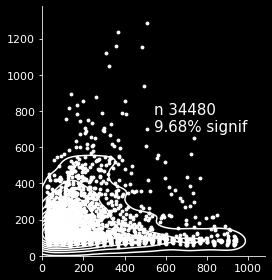

In [12]:
scDF = pivoted.loc[pivoted.analysis == 'single cell',:]

g = sns.FacetGrid(data=scDF, row=None, col=None, hue=None,
                  sharex=True, sharey=True, legend_out=True,
                  row_order=ana_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "integral (d'*ms)", color='white', fontsize=15)
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
# g.set_axis_labels("duration of contextual\ndiscrimination (ms)",
#                   "magnitude of contextual\ndiscrimination (d' * ms)")
g.set_axis_labels("",
                  "")
fig = g.fig
fig.set_size_inches(4, 4)
fig.tight_layout(rect=(0,0,0.98,0))

title = 'single_cell_parameter_space_pooled'

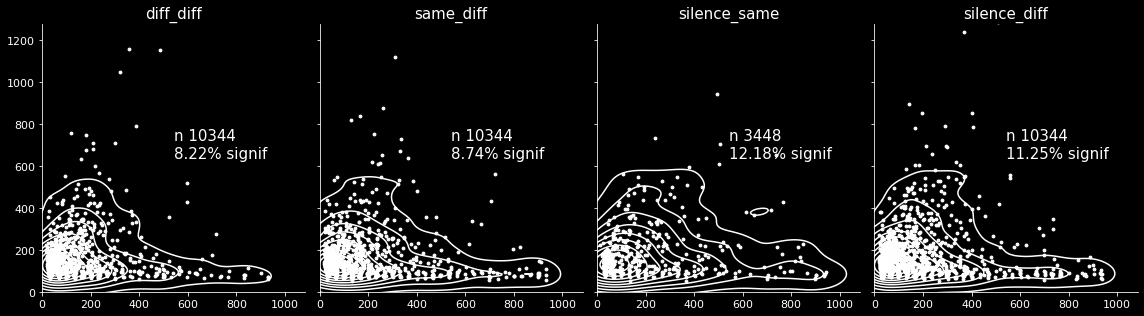

In [13]:
scDF = pivoted.loc[pivoted.analysis == 'single cell',:]
g = sns.FacetGrid(data=scDF, row=None, col='trans_pair', hue=None,
                  sharex=True, sharey=True, legend_out=True,
                  row_order=ana_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "integral (d'*ms)", color='white', fontsize=15)
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="", col_template="{col_name}")
g.set_axis_labels("",
                  "")
fig = g.fig
fig.set_size_inches(16,4.5)
fig.tight_layout(rect=(0,0,1,1))

title = 'single_cell_parameter_space_transitions'

<ipython-input-14-c5e65d90cc57>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout(rect=(0,0,0.98,0))


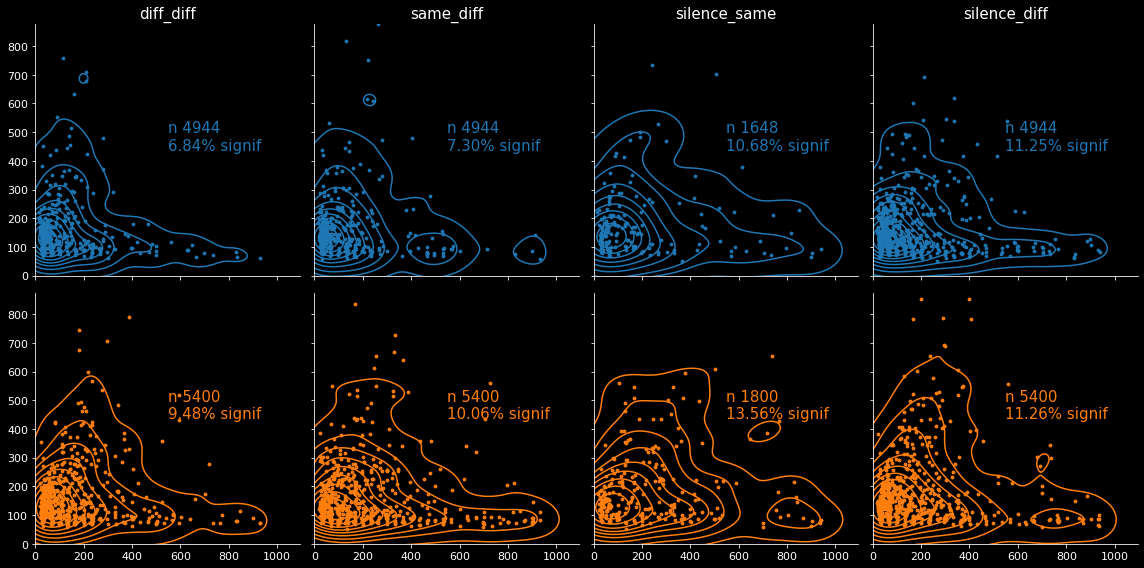

In [14]:
scDF = pivoted.loc[pivoted.analysis == 'single cell',:]
g = sns.FacetGrid(data=scDF, row='region', col='trans_pair', hue='region',
                  sharex=True, sharey=True, legend_out=True,
                  row_order=reg_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "integral (d'*ms)", fontsize=15)
g.set_titles(template="")
# g.set_axis_labels("duration of contextual\ndiscrimination (ms)",
#                   "magnitude of contextual\ndiscrimination (d' * ms)")
g.set_axis_labels("",
                  "")
g._margin_titles = True
g.set_titles(row_template="", col_template="{col_name}")
fig = g.fig
fig.set_size_inches(16,8)
fig.tight_layout(rect=(0,0,0.98,0))

title = 'single_cell_parameter_space_trans_region'

## Population

<ipython-input-15-573d10276fbd>:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout(rect=(0,0,0.98,0))


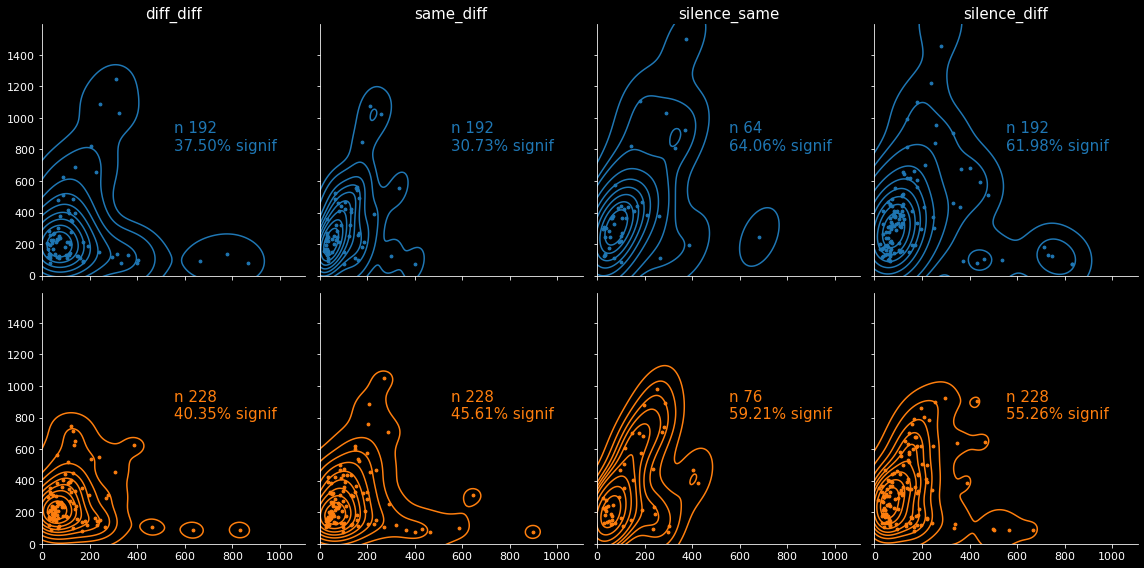

In [15]:
scDF = pivoted.loc[pivoted.analysis == 'population',:]
g = sns.FacetGrid(data=scDF, row='region', col='trans_pair', hue='region',
                  sharex=True, sharey=True, legend_out=True,
                  row_order=reg_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)',  "integral (d'*ms)", fontsize=15)
g.set_titles(template="")
g.set_axis_labels("",
                  "")
g._margin_titles = True
g.set_titles(row_template="", col_template="{col_name}")
fig = g.fig
fig.set_size_inches(16,8)
fig.tight_layout(rect=(0,0,0.98,0))

title = 'population_parameter_space_trans_region'

# Anova tables

In [16]:
for ana, met in itt.product(['single cell', 'population'], ['center of mass (ms)', "integral (d'*ms)"]):
    ff_metric = filtered.metric == met
    ff_analysis = filtered.analysis == ana
    ff_val = filtered.value > 0
    anovaDF =  filtered.loc[ff_metric & ff_analysis & ff_val,
                         ['region', 'trans_pair', 'value']]

    modstr = 'value ~ C(region) + C(trans_pair) + C(region):C(trans_pair)'
    model = ols(modstr, data=anovaDF).fit()
    df = sm.stats.anova_lm(model, typ=2)

    title =f'\n {ana} {met}'
    print(title)
    print(df)

    # post hoc comparisons
    res = stat()
    for comp in ['region', 'trans_pair']:
        res.tukey_hsd(df=anovaDF, res_var= 'value', xfac_var=comp, anova_model=modstr)
        phocdf = res.tukey_summary
        phocdf = phocdf.loc[:, ['group1', 'group2', 'p-value']]
        print('\n', phocdf)



 single cell center of mass (ms)
                               sum_sq      df          F        PR(>F)
C(region)                1.579921e+06     1.0  48.207189  4.590747e-12
C(trans_pair)            1.056350e+06     3.0  10.743926  5.030272e-07
C(region):C(trans_pair)  3.149195e+05     3.0   3.202984  2.232604e-02
Residual                 1.091359e+08  3330.0        NaN           NaN

   group1 group2  p-value
0    PEG     A1    0.001

          group1        group2   p-value
0  silence_same  silence_diff  0.027783
1  silence_same     same_diff  0.034926
2  silence_same     diff_diff  0.001000
3  silence_diff     same_diff  0.900000
4  silence_diff     diff_diff  0.002703
5     same_diff     diff_diff  0.005862

 single cell integral (d'*ms)
                               sum_sq      df         F    PR(>F)
C(region)                1.197519e+05     1.0  8.377019  0.003825
C(trans_pair)            1.147354e+05     3.0  2.675366  0.045648
C(region):C(trans_pair)  2.907397e+04     3.0  0

# post hoc comparisons


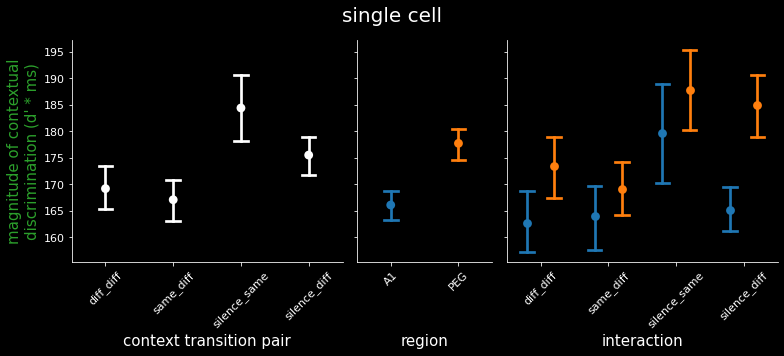

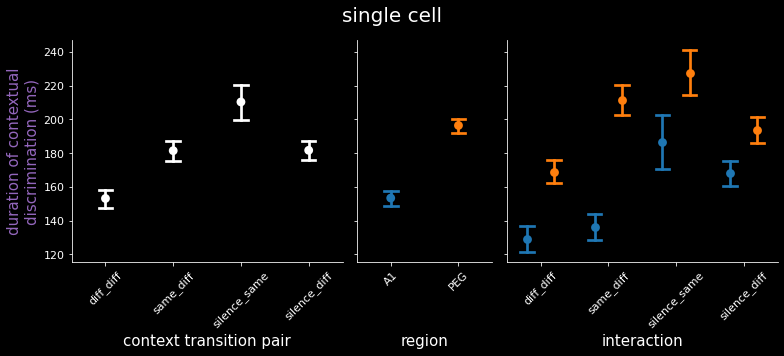

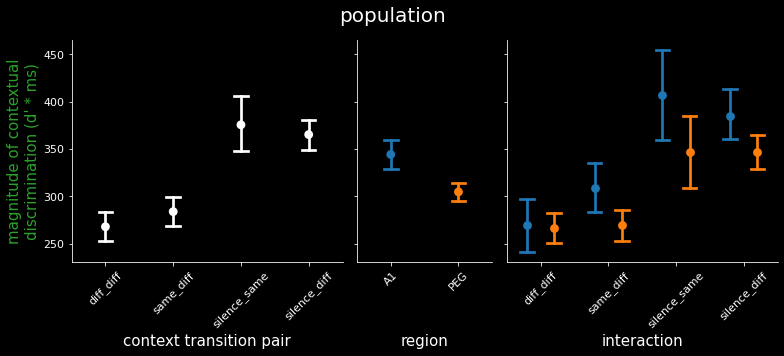

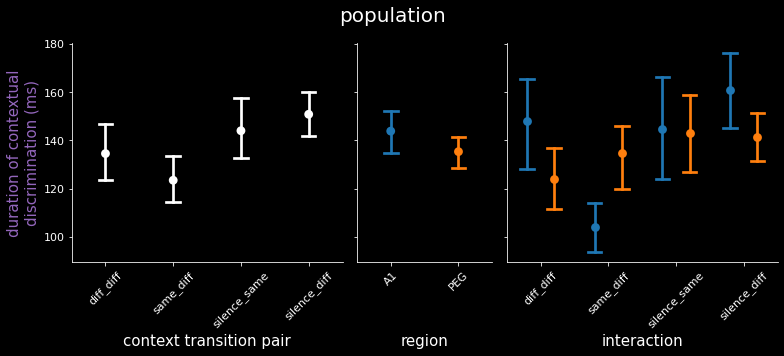

In [17]:
metric = "integral (d'*ms)"
# metric = "center of mass (ms)"
analysis = "single cell"
# analysis = "population"
metrics = ["integral (d'*ms)", "center of mass (ms)"]
analyses = ['single cell', 'population']
for analysis, metric in itt.product(analyses, metrics):
    tocalc = filtered.loc[(filtered.metric == metric) &
                          (filtered.analysis == analysis) &
                          (filtered.value >0),:]

    toplot = tocalc.loc[(tocalc.value < 600), :]

    if metric == "integral (d'*ms)":
        mname = 'integral'
        ylname = "magnitude of contextual\ndiscrimination (d' * ms)"
        lab_color = 'C2'
    elif metric == "center of mass (ms)":
        mname = 'center_of_mass'
        ylname = "duration of contextual\ndiscrimination (ms)"
        lab_color = 'C4'

    # plots the comparison by transition pair and by region in subplots of the same figures
    # gs_kw = dict(width_ratios=[1,0.5], height_ratios=[1])
    gs_kw = dict(width_ratios=[1, 0.5, 1], height_ratios=[1])
    # fig, (trans_ax, reg_ax) = plt.subplots(1, 2, sharey=True, gridspec_kw=gs_kw)
    fig, (trans_ax, reg_ax, int_ax) = plt.subplots(1, 3, sharey=True, gridspec_kw=gs_kw)
    fig.set_size_inches(11,5)

    #transitions
    _ = sns.pointplot(x='trans_pair', y='value', data=tocalc, order=trans_ord, hue_order=reg_ord,
                       s=2, dodge=0.4, join=False, palette=['white'], capsize=0.2, ci=68, ax=trans_ax)
    trans_ax.legend([],[], frameon=False)
    trans_ax.set_xticklabels(trans_ord, rotation = 45)

    trans_ax.set_xlabel('context transition pair')
    trans_ax.set_ylabel(ylname)
    trans_ax.yaxis.label.set_color(lab_color)

    # regions
    _ = sns.pointplot(x='region', y='value', data=tocalc, order=reg_ord, hue_order=reg_ord,
                       s=2, dodge=0.4, join=False, palette=sns.color_palette(), capsize=0.2, ci=68, ax=reg_ax)

    reg_ax.legend([],[], frameon=False)
    reg_ax.set_xticklabels(reg_ord, rotation = 45)
    reg_ax.set_xlabel('region')
    reg_ax.set_ylabel("")

    # interaction
    int_ax = sns.pointplot(x='trans_pair', y='value', hue='region', data=tocalc, order=trans_ord, hue_order=reg_ord,
                   s=2, dodge=0.4, join=False, capsize=0.2, ci=68, ax=int_ax)
    int_ax.legend([],[], frameon=False)
    int_ax.set_xticklabels(trans_ord, rotation = 45)
    int_ax.set_xlabel('interaction')
    int_ax.set_ylabel('')

    fig.align_labels()
    title =f'{analysis}_post_hoc_{mname}'
    fig.suptitle(f'{analysis}', fontsize=20)


# single cell population comparison

In [18]:
# display(pivoted)
indexed = pivoted
indexed['siteid'] = pivoted['id'].apply(lambda x: x[:7] )
indexed = indexed.set_index(['analysis', 'id', 'region', 'siteid', 'context_pair', 'trans_pair', 'probe'])

indexed = indexed.droplevel(1)
merge = pd.merge(left=indexed.loc['single cell'], right=indexed.loc['population'],
                 left_index=True, right_index=True,
                 suffixes=(' single cell', ' population'))
# display(merge)

filtmerge = merge.loc[(merge["integral (d'*ms) single cell"]>0) &
                      (merge["integral (d'*ms) population"]>0), :]
display(filtmerge)

metric                                          center of mass (ms) single cell  \
region siteid  context_pair trans_pair   probe                                    
A1     AMT020a 0_1          silence_diff 2                            30.117362   
                                         2                            64.531650   
                                         2                           399.802344   
                                         2                            51.859076   
                                         2                            64.027328   
...                                                                         ...   
PEG    CRD014b 0_4          silence_diff 2                            62.889175   
                            silence_same 4                            45.410574   
                                         4                            41.221770   
               2_3          same_diff    3                            32.183544   
               3_4          diff_diff    2                           192.872899   

metric                                          integral (d'*ms) single cell  \
region siteid  context_pair trans_pair   probe                                 
A1     AMT020a 0_1          silence_diff 2                         64.418293   
                                         2                        145.474499   
                                         2                         65.919987   
                                         2                        106.441125   
                                         2                        156.265410   
...                                                                      ...   
PEG    CRD014b 0_4          silence_diff 2                         95.917648   
                            silence_same 4                        173.704710   
                                         4                        126.727824   
               2_3          same_diff    3                         91.843043   
               3_4          diff_diff    2                        217.747403   

metric                                          mean d' single cell  \
region siteid  context_pair trans_pair   probe                        
A1     AMT020a 0_1          silence_diff 2                 0.644183   
                                         2                 0.872847   
                                         2                 0.659200   
                                         2                 0.798308   
                                         2                 1.562654   
...                                                             ...   
PEG    CRD014b 0_4          silence_diff 2                 0.959176   
                            silence_same 4                 1.302785   
                                         4                 1.267278   
               2_3          same_diff    3                 0.918430   
               3_4          diff_diff    2                 1.306484   

metric                                          center of mass (ms) population  \
region siteid  context_pair trans_pair   probe                                   
A1     AMT020a 0_1          silence_diff 2                           76.542105   
                                         2                           76.542105   
                                         2                           76.542105   
                                         2                           76.542105   
                                         2                           76.542105   
...                                                                        ...   
PEG    CRD014b 0_4          silence_diff 2                           33.886267   
                            silence_same 4                           39.368657   
                                         4                           39.368657   
               2_3          same_diff    3           

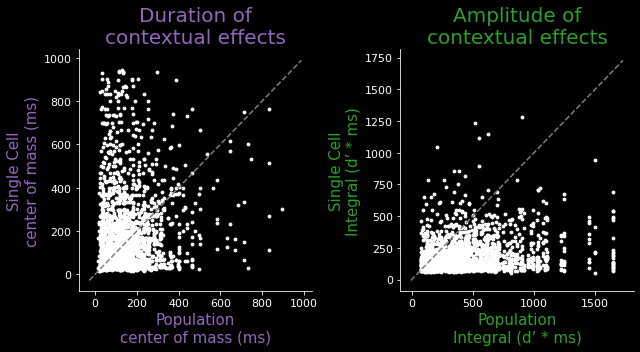

In [19]:
fig, (dur_ax, amp_ax) = plt.subplots(1,2)
fig.set_size_inches(9,5)

dur_ax.scatter(filtmerge.loc[:,"center of mass (ms) population"], filtmerge.loc[:,"center of mass (ms) single cell"],
               color='white', s=8)
dur_ax.set_xlabel("Population\ncenter of mass (ms)")
dur_ax.set_ylabel("Single Cell\ncenter of mass (ms)")
dur_ax.xaxis.label.set_color('C4')
dur_ax.yaxis.label.set_color('C4')
dur_ax.set_title('Duration of\ncontextual effects', color='C4')

amp_ax.scatter(filtmerge.loc[:,"integral (d'*ms) population"], filtmerge.loc[:,"integral (d'*ms) single cell"],
               color='white', s=8)
amp_ax.set_xlabel("Population\nIntegral (d’ * ms)")
amp_ax.set_ylabel("Single Cell\nIntegral (d’ * ms)")
amp_ax.xaxis.label.set_color('C2')
amp_ax.yaxis.label.set_color('C2')
amp_ax.set_title('Amplitude of\ncontextual effects', color='C2')

for ax in (dur_ax, amp_ax):
    _ = unit_line(ax, True)

title =f'SC_pop_metric_comparison'


# Example cell

In [20]:
best_cells = pivoted.loc[(pivoted.analysis == 'single cell') &
                         (pivoted['center of mass (ms)'] > 0),:]
# best_cells = best_cells.sort_values(by=["mean d'", 'center of mass (ms)'], ascending=[False, False])
best_cells = best_cells.sort_values(by=["integral (d'*ms)", 'center of mass (ms)'], ascending=[False, False])
display(best_cells.head(5))


metric,analysis,region,id,context_pair,trans_pair,probe,center of mass (ms),integral (d'*ms),mean d',siteid
34974,single cell,PEG,CRD012b-13-1,0_4,silence_diff,3,507.079994,1284.997683,1.482690,CRD012b
26961,single cell,PEG,ARM021b-36-8,0_1,silence_diff,3,369.224941,1238.284103,1.428789,ARM021b
26976,single cell,PEG,ARM021b-36-8,1_2,diff_diff,3,358.137677,1156.687105,1.388025,ARM021b
34985,single cell,PEG,CRD012b-13-1,1_4,diff_diff,3,484.889532,1151.055683,1.381267,CRD012b
2978,single cell,A1,AMT021b-05-2,1_2,same_diff,1,308.933576,1120.160911,1.527492,AMT021b


# psth and dprime plots for example cells/sites